### Lanczos Algorithm

I this short notebook, we implement the Lanczos algorithm. The aim is to obtain a function to use in DMRG routine.

Lanczos algorithm is a numerical recipe which aims to find a few largest eigenvalues and corresponding eigenvectors of a given matrix. It maps the problem into a smaller system without loss of generality for the lowest eigenvalues and vectors.


#### Generate a Hamiltonian

Given an b-by-n matrix $H$, our goal is to start from an n-by-1 (random) vector $v$ and find the true ground state vector.

For this purpose, we generate the k-th order Krylov space for $v$ as follows:
$$\mathcal{K}(H,v,n) = span\{v,Hv,H^2v,...,H^kv\}$$


Let us initiate all possible libraries in case needed.

In [25]:
# in case needed, sometimes the figures can be drawn with a seperate window
# the following two command enforces it to draw 'inline'
%matplotlib notebook

# ignore the warnings: can be useful for too many imag. part warnings 
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from numpy import (real,imag,matrix,linspace,array,complex)
from IPython.display import Image
from mpl_toolkits.mplot3d import axes3d

from numpy import *
import scipy

import numpy as np
import numpy.linalg as npl
import scipy as sp

from scipy.stats import norm

Let us also generate a random Hermitian matrix with up to $L$'th non-zero off-diagonals:

In [12]:
dx = 0.1
a = arange(-10.,10.,dx)
aN = len(a)
L = 2

H = np.array(zeros((aN,aN),dtype='complex'))
for i1 in arange(-L,L+1):
    H = H + np.diag(a[0:aN-abs(i1)]*exp(-abs(i1))+0.01,i1)

A Hermitian conjugate matrix is generated,

In [13]:
aN

200

<IPython.core.display.Javascript object>


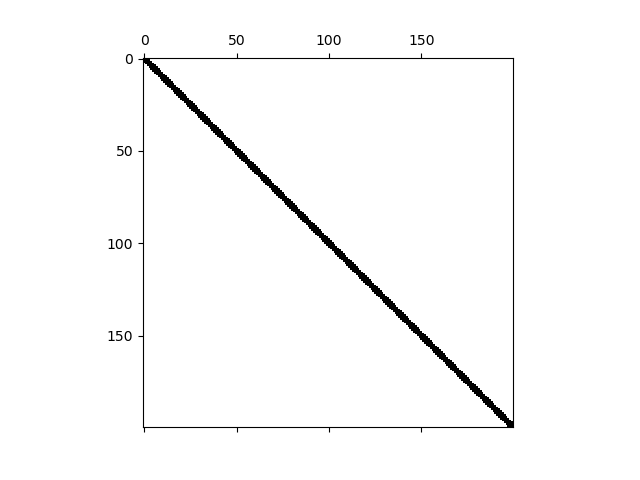

In [14]:
plt.spy(H.real)

In [15]:
abs(H).shape

(200, 200)

In [26]:
ei,vi = npl.eig(H)
ndee1=argsort(ei)
ei = ei[ndee1]
vi = vi[:,ndee1]
ei[0:3]

array([-18.66855782+0.j, -17.47991526+0.j, -16.53522927+0.j])

### Lanczos iteration

Basically, we search for the elements of the eigenvalue equation
$$H | v  \rangle = \lambda | v  \rangle$$

via $H = V T V^\dagger$, where $H$ is $n \times n$ whereas $T$ is $m \times m$ ($m \ll n$) such that a smaller eigenvalue equation for $T$ provide the same eigenvalues for a few lowest states as follow:
$$T | u  \rangle = \lambda | u  \rangle.$$

The trick is to propose such $V$ matrix which is $n \times m $. One can then easily show that $| v  \rangle = V | u  \rangle$.

In other words, we iteratively construct $V$ matrix, generate a tridiagonal $T$ matrix such that $T$ becomes diagonal when the convergence is reached. IT can also be shown as follows,

\begin{eqnarray}
V^\dagger H V &=& T,\\
V^\dagger H V | u \rangle &=& T | u \rangle,\\
V^\dagger H | v \rangle &=& \lambda | u \rangle,\\
\lambda V^\dagger | v \rangle &=& \lambda | u \rangle,\\
\lambda | u \rangle &=& \lambda | u \rangle
\end{eqnarray}

For vectors, we use the Dirac notation where $u = |u\rangle$ with the inner product $w^\dagger u = \langle w | u \rangle$.

One can also carry out this calculation step by step as follow,

1. Pick a random vector $u_1$ and set $| v_1 \rangle = | u_1 \rangle$,
2. generate $| v_{j+1} \rangle$ via Gram-Schmidt orthogonalization of $H | v_j \rangle$, as follows
- let $| u_{j+1}'  \rangle = H u_{j}$, obtain all vectors up to an arbitrary m$^{th}$ order.
- generate coefficients $g_k$ at each $j$ iteration for $k = 1,2, ..., j$, i.e. $g_{k,j} = \langle v_k | u_{j+1}' \rangle$, non-zero coefficients indicate a finite overlap of $| u_{j+1}' \rangle$ with the previous vectors.

- Let $| w_{j+1}  \rangle = |u_{j+1}' \rangle - g_{1,j} | v_{1}  \rangle - g_{2,j} | v_{2}  \rangle - .. - g_{j,j} | v_{j}  \rangle$

- then, $| v_{j+1}  \rangle =| w_{j+1}  \rangle/\beta_j$ with $\beta_j=\langle w_{j+1} | w_{j+1} \rangle $. Moreover, $| u_{j+1}  \rangle =| u_{j+1}'  \rangle/\langle u_{j+1}' | u_{j+1}'  \rangle $

3. One can then find an equation relating $H | u_{j}  \rangle$ with orthogonal vectors

\begin{eqnarray}
H | u_{j}  \rangle &=& | w_{j+1}  \rangle + \sum_{k=1}^j g_{k,j} v_k,\\
H | u_{j}  \rangle=| u_{j+1}'  \rangle &=& \beta_{j+2} | v_{j+1}  \rangle + \sum_{k=1}^j g_{k,j} | v_{k}  \rangle,\\
\end{eqnarray}

Let me contract by $\langle v_l |$,
\begin{eqnarray}
\langle v_l |H | u_{j}  \rangle &=& \beta_{j+2} \langle v_l | v_{j+1}  \rangle + \sum_{k=1}^j g_{k,j} \langle v_l | v_{k}  \rangle,\\
g_{l,j} &=& \beta_{j+2} \delta_{l,j+1} + g_{l,j} \Theta (j-l)
\end{eqnarray}

\begin{eqnarray}
| v_2 \rangle &=& H | v_1 \rangle - \Big[(H | v_1 \rangle )^\dagger | v_1 \rangle \Big] | v_1 \rangle, \quad \alpha_1 = \langle v_1 | H | v_1 \rangle \\
&=& H | v_1 \rangle - \alpha_1 | v_1 \rangle.
\end{eqnarray}

In [32]:
v0 = np.random.rand(aN,)
v0 = v0/npl.norm(v0)

threshold = 1e-2
error = 1.
count = 0
maxIt = 89

# kolay vektör initialization yolu
ee0,ee1,ee2,eer0,eer1 = [np.array(np.zeros((maxIt,),dtype='double')) for _ in np.arange(5)]

#while (error > threshold) and (count < maxIt):
for k in np.arange(3,maxIt+1):
    MM = min(k,2)
    vjVec = np.array(np.zeros((aN,k),dtype='complex')) 
    aVec,bVec = [np.array(np.zeros((k,),dtype='complex')) for _ in np.arange(2)]
    vjVec[:,0] = v0;
    if k==3:
        vjVec[:,0] = v0;
    else:
        vjVec[:,0:MM] = vv[:,0:MM];
    
    wjp = np.dot(H,vjVec[:,0])
    aVec[0]= np.dot(conj(wjp).T,vjVec[:,0])
    wj = wjp - aVec[0]*vjVec[:,0]

    for i2 in arange(1,k):
        bVec[i2] = npl.norm(wj)
        if bVec[i2] != 0.:
            vj = wj/bVec[i2]
        else:
            vj = np.random.rand(aN,)
        vSub = np.array(np.zeros((aN,),dtype='complex'))
        for i3 in arange(i2):
            vSub = vSub + dot(vjVec[:,i3],vj)*vjVec[:,i3]
        vj = vj-vSub 
        vj= vj/npl.norm(vj)

        vjVec[:,i2] = vj
        wjp= np.dot(H,vj)
        aVec[i2] = dot(conj(wjp).T,vj)
        wj = wjp - aVec[i2]*vj - bVec[i2]*vjVec[:,i2-1]

    T = diag(aVec)+diag(bVec[1:],1)+diag(bVec[1:],-1)
    
    etI,vtI = npl.eig(T)
    ndee=argsort(etI)
    vtI = vtI[:,ndee[0:MM]]
    etI = etI[ndee[0:MM]]

    error = npl.norm(bVec)
    error = npl.matrix_rank(vjVec)
    vv = dot(vjVec,vtI)

    ee0[k-1] = etI[0]
    ee1[k-1] = etI[1]
    eer0[k-1] = npl.norm(etI[0]*np.dot(vjVec,vtI[:,0])-np.dot(H,np.dot(vjVec,vtI[:,0])))
    eer1[k-1] = npl.norm(etI[1]*np.dot(vjVec,vtI[:,1])-np.dot(H,np.dot(vjVec,vtI[:,1])))


<IPython.core.display.Javascript object>


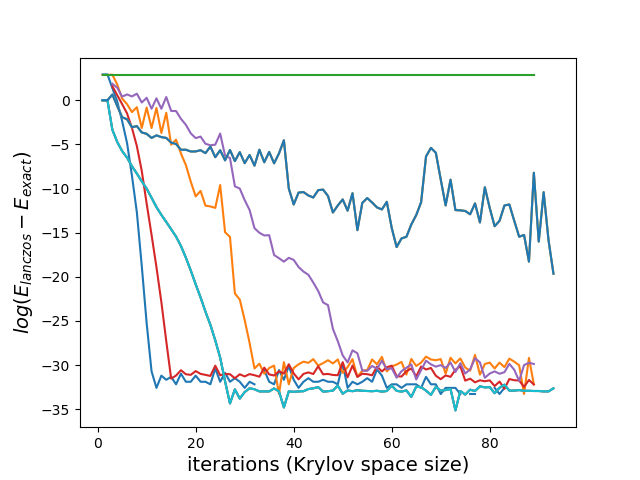

In [34]:
plt.plot(np.arange(1,k+1),log(abs(ee0-ei[0])),np.arange(1,k+1),log(abs(ee1-ei[1])),np.arange(1,k+1),log(abs(ee2-ei[2])))

In [37]:
plt.plot(np.arange(1,k+1),log(eer0),np.arange(1,k+1),log(eer1))

In [38]:
print(ei[0:2],etI[0:2])

[-18.66855782+0.j -17.47991526+0.j] [-18.66855782+0.j -17.47991526+0.j]


the take away message is that the original matrix $H$ must be reproduced as follows. If $u$ and $\lambda$ are the eigen- vectors and values and if $\lambda$ is also the eigenvalue of $H$, then the eigenvector of $H$, $v$ is,
$$v = V u$$
and
$$H = V T V^\dagger$$

we are now ready to define our Lanczos function:

### a function for Lanczos Algorithm
#### Full Hilbert Space

In [58]:
def LancFirat(H,Logsensitivity):
    %matplotlib notebook
    aN = H.shape[0]
    v0 = np.random.rand(aN,)
    v0 = v0/npl.norm(v0)
    threshold = 1e-2
    error = 1.
    count = 0
    maxIt = aN
    ee0,ee1,ee2,eer0,eer1 = [np.array(np.zeros((maxIt,),dtype='double')) for _ in np.arange(5)]

    k = 3
    erLog = 1
    Trank = 3
    while erLog>Logsensitivity or (abs(Trank-k)>4):# check this part and k <= aN):
        MM = min(k,3)
        vjVec = np.array(np.zeros((aN,k),dtype='complex')) 
        aVec,bVec = [np.array(zeros((k,),dtype='complex')) for _ in np.arange(2)]
        if k==3:
            vjVec[:,0] = v0
        else:
            vjVec[:,0:MM] = vv[:,0:MM]
        wjp = np.dot(H,vjVec[:,0])
        aVec[0]= np.dot(conj(wjp).T,vjVec[:,0])
        wj = wjp - aVec[0]*vjVec[:,0]

        for i2 in np.arange(1,k):
            bVec[i2] = npl.norm(wj)
            if bVec[i2] != 0.:
                vj = wj/bVec[i2]
            else:
                vj = np.random.rand(aN,)
                #print(i2)
            vSub = np.array(np.zeros((aN,),dtype='complex'))
            for i3 in arange(i2):
                vSub = vSub + dot(vjVec[:,i3],vj)*vjVec[:,i3]
            vj = vj-vSub 
            vj= vj/npl.norm(vj)

            vjVec[:,i2] = vj
            wjp= np.dot(H,vj)
            aVec[i2] = np.dot(conj(wjp).T,vj)
            wj = wjp - aVec[i2]*vj - bVec[i2]*vjVec[:,i2-1]

        T = np.diag(aVec)+np.diag(bVec[1:],1)+np.diag(bVec[1:],-1)
        
        etI1,vtI1 = npl.eig(T)
        ndee = np.argsort(etI1)
        vtI1 = vtI1[:,ndee[0:MM]]
        etI1 = etI1[ndee[0:MM]]

        error = npl.norm(bVec)
        Trank = npl.matrix_rank(vjVec)
        vv= np.dot(vjVec,vtI1)

        ee0[k-1] = etI1[0]
        ee1[k-1] = etI1[1]
        ee2[k-1] = etI1[2]
        eer0[k-1] = npl.norm(etI1[0]*np.dot(vjVec,vtI1[:,0])-np.dot(H,np.dot(vjVec,vtI1[:,0])))
        eer1[k-1] = npl.norm(etI1[1]*np.dot(vjVec,vtI1[:,1])-np.dot(H,np.dot(vjVec,vtI1[:,1])))
        
        #eer0[k-1] = abs(ee0[k-1]-(ee0[k-2]+ee0[k-3])/2.)
        #eer1[k-1] = abs(ee1[k-1]-(ee1[k-2]+ee1[k-3])/2.)
        erLog = log(eer0[k-1]+eer1[k-1])
        #print(erLog)
        eer = [eer0,eer1]
        k += 1
    return etI1,vv,k,ee0,ee1,ee2,eer0,eer1

In [59]:
L = 100
H = np.diag(np.ones((L,),dtype='double'))-np.diag(np.ones((L-1,),dtype='double'),1)-np.diag(np.ones((L-1,),dtype='double'),-1)
ei,vi = npl.eig(H)
ndee1 = np.argsort(ei)
ei    = ei[ndee1]
vi    = vi[:,ndee1]
ei[0:3]

array([-0.99903256, -0.99613119, -0.9912987 ])

In [60]:
print(H.shape)

(100, 100)


In [61]:
etI,vtI,k,ee0,ee1,ee2,eer0,eer1 = LancFirat(H,-10)

In [62]:
print([ee0[k-2],ee1[k-2],ee2[k-2]])

[-0.999032564583977, -0.9961311895357854, -0.9912979806486321]


In [63]:
k

77

<IPython.core.display.Javascript object>


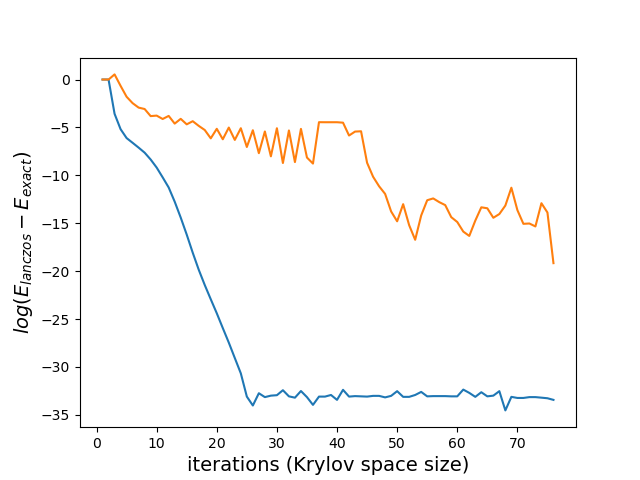

Text(0, 0.5, '$log(E_{lanczos}-E_{exact})$')

In [65]:
plt.plot(np.arange(1,k),log(abs(ee0[0:k-1]-ei[0])),np.arange(1,k),log(abs(ee1[0:k-1]-ei[1])))
plt.xlabel("iterations (Krylov space size)",size=14)
plt.ylabel("$log(E_{lanczos}-E_{exact})$",size=14)


<IPython.core.display.Javascript object>


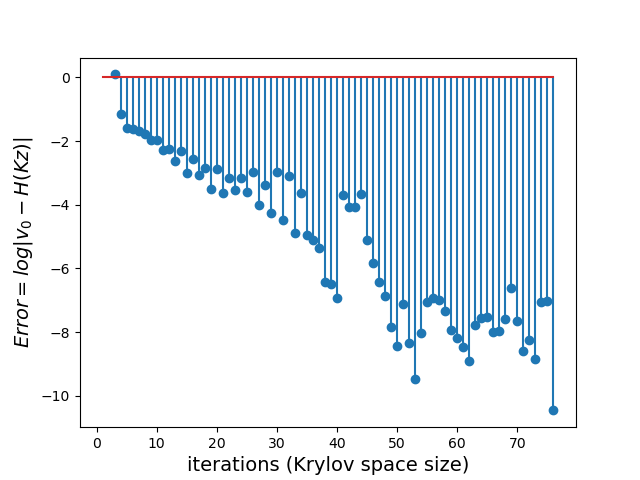

Text(0, 0.5, '$Error= log|v_0 - H (K z) |$')

In [68]:
%matplotlib notebook

plt.stem(np.arange(1,k),log(eer0[0:k-1]+eer1[0:k-1]))
plt.xlabel("iterations (Krylov space size)",size=14)
plt.ylabel("$Error= log|v_0 - H (K z) |$",size=14)

### One example: Heisenberg Chain


The spin-$1/2$ Hamiltonian is,
$$H = J \sum_{\langle ij \rangle} S_i \cdot S_j$$

In [69]:
def XXZ_Ham(J,Jz,L):
    Sigx = 0.5*np.array([[0.,1.],[1.,0.]])
    Sigy = 0.5j*np.array([[0.,-1.],[1.,0.]])
    Sigz = 0.5*np.array([[1.,0.],[0.,-1.]])
    Sigp = Sigx+1j*Sigy
    Sigm = Sigx-1j*Sigy

    SigXX = np.kron(Sigx,Sigx)
    SigYY = np.kron(Sigy,Sigy)
    SigZZ = np.kron(Sigz,Sigz)
    SigPMMP = 0.5*np.kron(Sigp,Sigm)+0.5*np.kron(Sigm,Sigp)
    H_Heis = np.array(np.zeros((2**L,2**L),dtype='complex'))
    for i1 in np.arange(L-1):
        Hij = (SigPMMP+Jz*SigZZ)
        # 2**i'lik identity matrix kullan
        for i2 in np.arange(i1):
            Hij = np.kron(eye(2),Hij)
        for i2 in np.arange(i1+2,L):
            Hij = np.kron(Hij,eye(2))
        H_Heis = H_Heis + Hij
    return H_Heis

In [70]:
L = 12
J = 1.
Jz = 1.
H_Heis = XXZ_Ham(J,Jz,L)

<IPython.core.display.Javascript object>


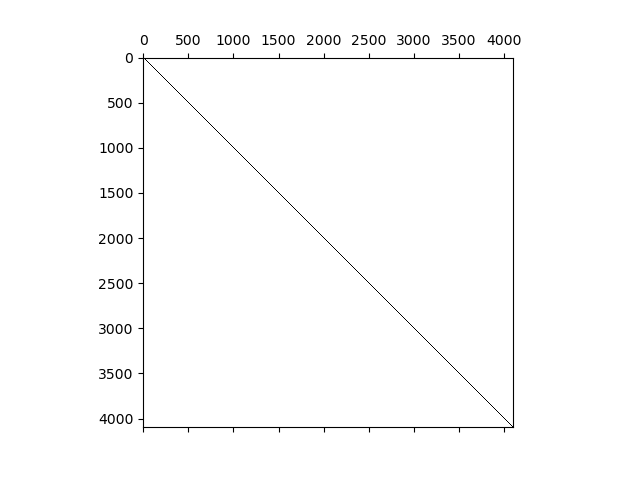

In [73]:
%matplotlib notebook
plt.spy(H_Heis)

In [74]:
etI,vtI,k,ee0,ee1,ee2,eer0,eer1 = LancFirat(H_Heis,-25)

<IPython.core.display.Javascript object>


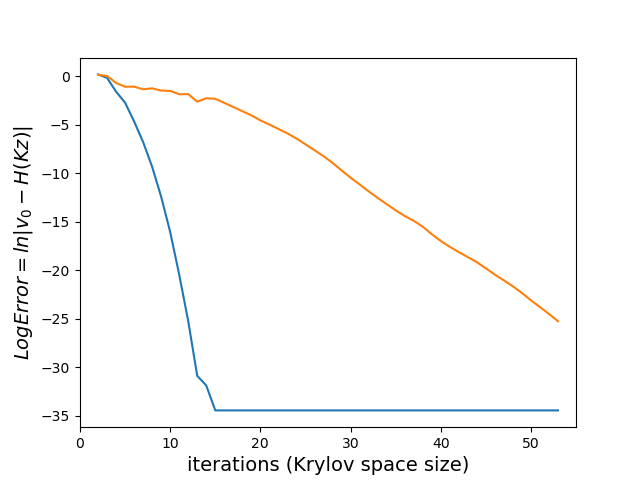

(0.0, 55.0)

In [75]:
plt.plot(np.arange(2,k-1),log(eer0[2:k-1]),np.arange(2,k-1),log(eer1[2:k-1]))
plt.xlabel("iterations (Krylov space size)",size=14)
plt.ylabel("$Log Error= ln|v_0 - H (K z) |$",size=14)
plt.xlim((0,k))

<IPython.core.display.Javascript object>


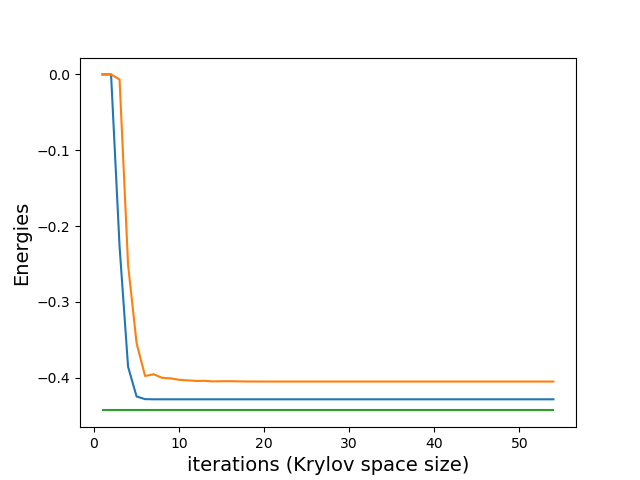

Text(0, 0.5, 'Energies')

In [78]:
%matplotlib notebook
plt.plot(np.arange(1,k),ee0[0:k-1]/L,np.arange(1,k),ee1[0:k-1]/L,np.arange(1,k),(0.25-log(2))*np.arange(1,k)/arange(1,k))
plt.xlabel("iterations (Krylov space size)",size=14)
plt.ylabel("Energies",size=14)

It is clear that even 14-site chain allocates an enormously large memory, therefore it begs for using the symmetries.

#### Symmetries

The symmetries can be used to decouple quantum numbers of the symmetry operator since $[H,A] = 0$. Therefore, symmetries such as
- $\text{translation}$: decoupled momentum numbers
- $\text{rotation}$: angular momentum, (l,m)
- $\text{SU(2) rotation}$: spin angular momentum, (s,m_s)
- $\text{time-reversal}$: Kramer's dublets
- $\text{inversion}$: 
- $\text{charge-conjugation}$: $\pm$ energy pairs and wavefunctions

can be exploited to restrict the Hilbert space size by a suitable choice of subspace basis vectors.

For the Heisenberg model, we will utilize the conservation of the total spin angular momentum and its z-projection, $[H,\sum_i S_i^2] = [H,\sum_i S_i^z] = 0$. This can be proved using the Jacobi coordinates one of which can simply be chosen as the 'center of mass'. We therefore choose the mutual basis for $\{ H, S, S^z \}$ as $\{ | n; S,M_S \rangle\}$.

We indeed know that $H = J \sum_{\langle ij \rangle} S_i \cdot S_j$ has AF-Neel order ($S_z = 0$) for $J>0$, therefore we can examine each $S^z$ subspace seperately.

Before moving into two-solutions, we state that the following convention is used for the kronecker product of the local spinors:

\begin{eqnarray}
\mid \Psi \rangle &=& \mid \uparrow \rangle \otimes \mid \downarrow\rangle  \otimes \mid \downarrow \rangle \otimes \mid \downarrow\rangle ...  \otimes \mid \uparrow \rangle \otimes \mid \uparrow \rangle  \otimes \mid \downarrow \rangle,\\
&=& \mid \uparrow \downarrow \downarrow \downarrow ... \uparrow \uparrow \downarrow \rangle \\
&=& \mid 1000 ... 110 \rangle
\end{eqnarray}

Moreover, $n$th orthonormal vector $\underline{a}$ (of size $L$) of the M dimensional Hilbert space (from $1$ to $M$) are represented (in base-2) $$\mid \Psi \rangle = \mid \underline{a}^n \rangle = \mid a^n_1 a^n_2 ... a^n_L \rangle$$

## Method 1:

- #### 1.1 generate the Hilbert space vector for S_z = 0

The total number of states are $2^L$ and the number of $S_z = 0$ states are:
$$M = \begin{pmatrix}L \\ L/2\end{pmatrix}$$

In [80]:
import math
import scipy.special
math.factorial(6)

L =16
x = np.arange(L+1)*1.
M = np.zeros((L+1,))
for iL in arange(L):
    M[iL] = math.factorial(L)/(math.factorial(x[iL])*math.factorial(L-x[iL]))
plt.plot(x,M)
2**L

65536

In [81]:
from itertools import permutations
L = 10
Nup = int(L/2)
vec0 = np.reshape([zeros((1,Nup)),ones((1,L-Nup))],(L,))
Hilb = permutations(vec0)
vecs = np.array(list(Hilb))

In [82]:
from itertools import combinations
from itertools import permutations

def combs(N, X):
    idx = np.array(list(combinations(range(N), X)))
    n = len(idx)
    out = np.zeros((n,N), dtype=int)
    out[np.arange(n)[:,None],idx] = 1
    return out

In [83]:
UnVecs=combs(L,Nup)

Cheking the size of Hilber-space, it must be M = 252 for each vector of size L.

In [84]:
UnVecs.shape

(252, 10)

In [85]:
UnVecs[arange(252),:]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

Find the indices of the matching vectors in the original basis. For this purpose, we need to remember how the original basis is sorted:

$$\mid \Psi \rangle = \begin{pmatrix} \mid \uparrow \rangle\\ \mid \downarrow \rangle \end{pmatrix}_1 \otimes \begin{pmatrix} \mid \uparrow \rangle\\ \mid \downarrow \rangle \end{pmatrix}_2 ... \otimes \begin{pmatrix} \mid \uparrow \rangle\\ \mid \downarrow \rangle \end{pmatrix}_L = \begin{pmatrix} \mid \uparrow \uparrow \uparrow ... \uparrow \uparrow \rangle\\ \mid \uparrow \uparrow \uparrow ... \uparrow \downarrow  \rangle\\ \mid \uparrow \uparrow \uparrow ... \downarrow \uparrow \rangle\\
\mid \uparrow \uparrow \uparrow ... \downarrow \downarrow \rangle\\ . \\ . \\\mid \downarrow\downarrow\downarrow ... \downarrow\downarrow \rangle \end{pmatrix} 
\equiv 
\begin{pmatrix} \mid 111 ... 11 \rangle\\ \mid 111 ... 10  \rangle\\ \mid 111 ... 01 \rangle\\
\mid 111 ... 00\rangle\\ . \\ . \\\mid 000 ... 00 \rangle \end{pmatrix} =
\begin{pmatrix} \mid 2^L-1 \rangle\\ \mid 2^L-2 \rangle\\\mid 2^L-3 \rangle\\
\mid 2^L-4\rangle\\ . \\ . \\\mid 0 \rangle \end{pmatrix}$$

Therefore, the base-10 values of our subspace vectors are indeed the row (or column) indices of the original Hamiltonian. Actually, the index is $\mid \text{row index} -(2^{L-1}-1) \mid$ 

For this purpose, let us first obtain the base-10 values of the $S^z = 0$ subspace vectors,

In [86]:
L = 10
Nup = int(L/2 +1)
J = 1.
Jz = 1.
H_Heis = XXZ_Ham(J,Jz,L)
UnVecs=combs(L,Nup)

HIndicesSz0 = abs(np.dot(UnVecs,2**arange(L-1,-1,-1))-2**L+1)
HIndicesSz0[1:10]

array([23, 27, 29, 30, 39, 43, 45, 46, 51])

The next task is to create a meshgrid and fetch the concetenated matrix $H(S^z=0)$ as the only non-zero entries within either the rows or the columns of these indices.

In [87]:
[xx,yy]= meshgrid(HIndicesSz0,HIndicesSz0)
H_HeisRed = H_Heis[xx,yy]

In [88]:
H_HeisRed.shape

(210, 210)

In [89]:
etI,vtI,k,ee0,ee1,ee2,eer0,eer1 = LancFirat(H_HeisRed,-25)

<IPython.core.display.Javascript object>


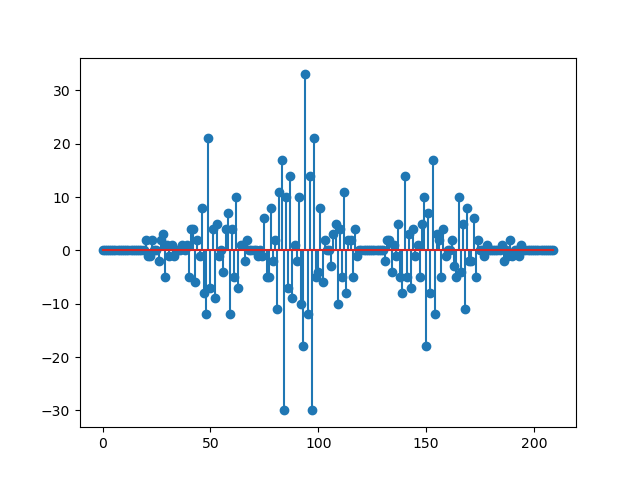

<StemContainer object of 3 artists>

In [90]:
plt.stem(fix(real(vtI*100))[:,0])

<IPython.core.display.Javascript object>


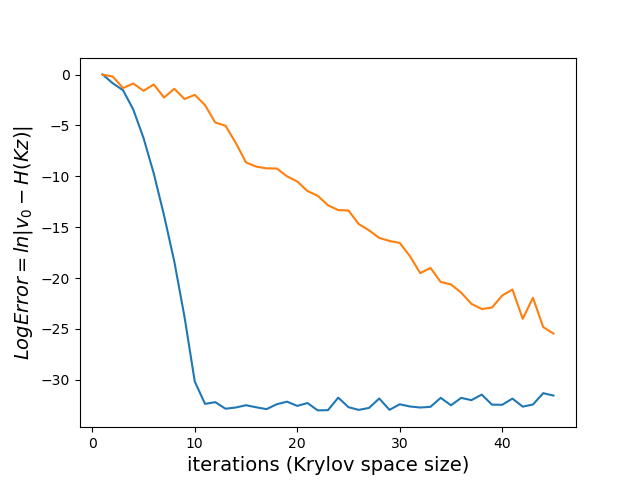

Text(0, 0.5, '$Log Error= ln|v_0 - H (K z) |$')

In [92]:
%matplotlib notebook
plt.plot(arange(1,k),log(eer0[2:k+1]),arange(1,k),log(eer1[2:k+1]))
plt.xlabel("iterations (Krylov space size)",size=14)
plt.ylabel("$Log Error= ln|v_0 - H (K z) |$",size=14)

<IPython.core.display.Javascript object>


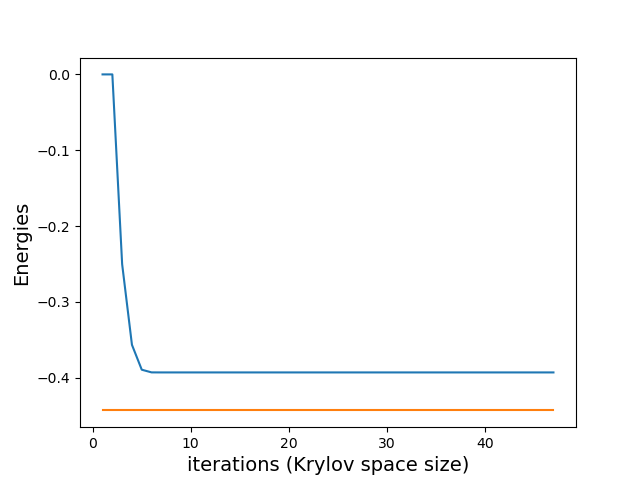

Text(0, 0.5, 'Energies')

In [95]:
%matplotlib notebook
plt.plot(np.arange(1,k),ee0[0:k-1]/(L),np.arange(1,k),(0.25-log(2))*ones((k-1,)))
plt.xlabel("iterations (Krylov space size)",size=14)
plt.ylabel("Energies",size=14)

We can plot the energies as a function total spin.

In [96]:
L = 10

J = 1.
Jz = 1.
H_Heis = XXZ_Ham(J,Jz,L)
Lloop = 5

EnVecs = np.zeros((3,Lloop))
for StotZ in np.arange(Lloop):
    Nup = int(L/2 + StotZ)
    UnVecs = combs(L,Nup)
    HIndicesSz0 = abs(np.dot(UnVecs,2**arange(L-1,-1,-1))-2**L+1)
    [xx,yy]= meshgrid(HIndicesSz0,HIndicesSz0)
    H_HeisRed = H_Heis[xx,yy]
    etI,vtI,k,ee0,ee1,ee2,eer0,eer1 = LancFirat(H_HeisRed,-25)
    EnVecs[:,StotZ] = etI[0:3]

<IPython.core.display.Javascript object>


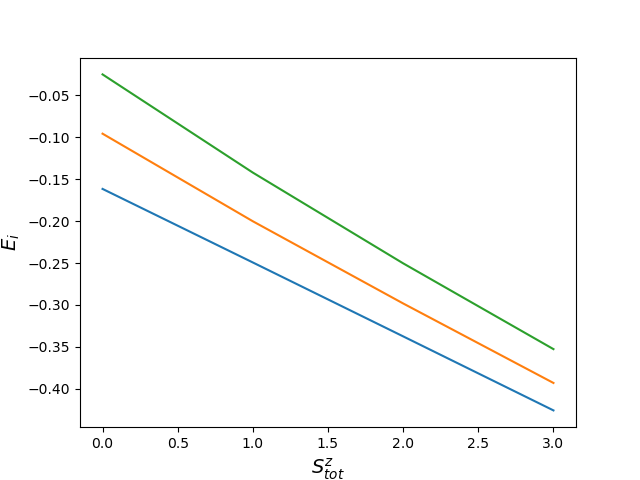

Text(0, 0.5, '$E_i$')

In [123]:
%matplotlib notebook
plt.plot(np.arange(Lloop),EnVecs[0,:]/L,np.arange(Lloop),EnVecs[1,:]/L,np.arange(Lloop),EnVecs[2,:]/L)
plt.xlabel('$S^z_{tot}$',size=14)
plt.ylabel('$E_i$',size=14)

plot the energies as a function of chain size

In [104]:
J = 1.
Jz = 1.
Lmin = 2
Lmax = 5
Lloop = Lmax - Lmin + 1
EnVecs = np.zeros((3,Lloop))
Lvec = np.arange(Lmin,Lmax+1)
for L1 in Lvec:
    L = int(2*L1)
    H_Heis = XXZ_Ham(J,Jz,L)
    Nup = int(L/2)
    UnVecs=combs(int(L),int(Nup))
    HIndicesSz0 = abs(np.dot(UnVecs,2**np.arange(L-1,-1,-1))-2**L+1)
    [xx,yy]= meshgrid(HIndicesSz0,HIndicesSz0)
    H_HeisRed = H_Heis[xx,yy]
    etI,vtI,k,ee0,ee1,ee2,eer0,eer1 = LancFirat(H_HeisRed,-25)
    EnVecs[:,L1-Lmin] = etI[0:3]

<IPython.core.display.Javascript object>


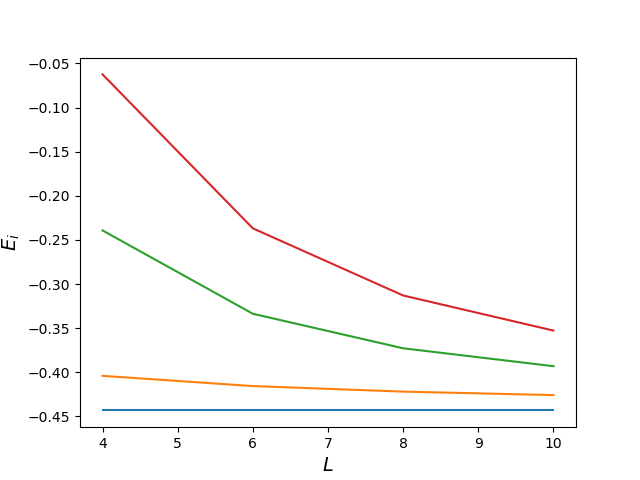

Text(0, 0.5, '$E_i$')

In [121]:
%matplotlib notebook
plt.plot(Lvec*2,np.ones((len(Lvec),))*(1/4.-log(2)),Lvec*2,EnVecs[0,:]/Lvec/2,Lvec*2,EnVecs[1,:]/Lvec/2,2*Lvec,EnVecs[2,:]/Lvec/2)
plt.xlabel('$L$',size=14)
plt.ylabel('$E_i$',size=14)

## Method 2: 
This method constructs the Hamiltonian directly from the Hilbert space vectors
Let us proceed step by step:

- #### 2.2. generate the Hamiltonian matrix in the subspace

In [108]:
L = 10
Nup = int(L/2)
J = 1.
Jz = 1.
UnVecs=combs(L,Nup)
Hlen = len(UnVecs)

In [109]:
UnVecs

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]])

The diagonal elements are generated through the Ising part, $\sum_i s^z_i s^z_{i+1}$,

\begin{eqnarray}
H_{ij} &=& \langle \underline{a}^i \mid \sum_{m=1}^{L-1} s^z_m s^z_{m+1}  \mid \underline{a}^j \rangle,\\
&=& \delta_{ij} \sum_{m=1}^{L-1} (a^i_m -1/2) (a^i_{m+1}-1/2)
\end{eqnarray}

In [110]:
diag0Vec = sum((UnVecs[:,0:L-1]-0.5)*(UnVecs[:,1:L]-0.5),1)

The off-diagonal Hamiltonian matrix elements are generated by XX term, $\frac{1}{2}\sum_i s^+_i s^-_{i+1}+s^-_i s^+_{i+1}$. It is not that trivial to calculate.

As a first step, let us first create an array of our vectors, 

$$\mathcal{H}_{S_z=0} = \begin{pmatrix} \mid \underline{a}^1 \rangle \\ \mid \underline{a}^2 \rangle\\ . \\.\\.\\ \mid \underline{a}^M  \rangle \end{pmatrix} = \begin{pmatrix} \mid a^1_1,a^1_2,...,a^1_L \rangle \\ \mid a^2_1,a^2_2,...,a^2_L\rangle\\ . \\.\\.\\ \mid a^M_1,a^M_2,...,a^M_L \rangle \end{pmatrix}, \quad a^i_j \in \{0,1\}$$

this is an $M \times L$ matrix,

the main observation is as follows:
- Heisenberg Hamiltonian has a nearest-neighbor character $s^+_i s^-_{i+1}+s^-_i s^+_{i+1}$, we have to examine 2 adjacent index each time. we, therefore, create a new matrix where we sum each adjacent element of the same vector,  
$$\mathcal{B} = \begin{pmatrix}\mid (a^1_1+a^1_2),(a^1_2+a^1_3),...,(a^1_{L-1}+a^1_L) \rangle \\ \mid (a^1_1+a^1_2),(a^2_2+a^2_3),...,(a^2_{L-1}+a^2_L) \rangle\\ . \\.\\.\\ \mid (a^M_1+a^M_2),(a^M_2+a^M_3),...,(a^M_{L-1}+a^M_L)\rangle \end{pmatrix} 
= \begin{pmatrix} \mid b^1_1,b^1_2,...,b^1_{L-1} \rangle \\ \mid b^2_1,b^2_2,...,b^2_{L-1}\rangle\\ . \\.\\.\\ \mid b^M_1,b^M_2,...,b^M_{L-1} \rangle \end{pmatrix}, \quad b^i_j \in \{0,1,2\}$$

- Here, when 

$b^i_j = 0$ the spin pair is $\mid 00 \rangle = \mid \downarrow \downarrow\rangle$

$b^i_j = 1$ the spin pair is $\mid 10 \rangle = \mid \uparrow\downarrow \rangle$ or $\mid 01 \rangle = \mid \downarrow \uparrow \rangle$

$b^i_j = 2$ the spin pair is $\mid 11 \rangle = \mid \uparrow\uparrow \rangle$

- XX term acts only on the adjacent sites with different spins, therefore only matrix elements with $b^i_j = 1$ terms match. 

For upcoming purposes, we calculated $\mathcal{B}$ (bbOverlap) along with overlap coeffs of $\mathcal{H}_{S_z=0}$ (aOverlap):

In [111]:
interm = mod(UnVecs[:,0:L-1]+UnVecs[:,1:L],2)
xL,yL = interm.shape
bbOverlap = zeros((xL,yL,Hlen))
for i1 in arange(Hlen):
    bbOverlap[:,:,i1] = interm[i1,:]*interm

For example, let us calculate the matrix elements for $s^+_1 s^-_{2}+s^-_1 s^+_{2}$,
- when acts on a vector $(s^+_1 s^-_{2}+s^-_1 s^+_{2}) \begin{pmatrix}\mid 10 \rangle \\ \mid 01 \rangle \end{pmatrix} = \begin{pmatrix}\mid 01 \rangle \\ \mid 10 \rangle \end{pmatrix}$. The possible outcomes are,

$$(s^+_1 s^-_{2}+s^-_1 s^+_{2}) \begin{pmatrix}\mid 11, a^i_3, a^i_4 ,...,a^i_L \rangle\\\mid 10, a^i_3, a^i_4 ,...,a^i_L \rangle \\ \mid 01 , a^i_3, a^i_4,...,a^i_L \rangle \\\mid 00, a^i_3, a^i_4 ,...,a^i_L \rangle \end{pmatrix} = \begin{pmatrix}0\\\mid 01, a^i_3, a^i_4 ,...,a^i_L \rangle \\ \mid 10 , a^i_3, a^i_4,...,a^i_L \rangle \\0\end{pmatrix}$$

- Therefore, we could have non-zero elements for the cross terms of $\mid 01 \rangle$ and $\mid 10 \rangle$.
It means, for $s^+_n s^-_{n+1}+s^-_n s^+_{n+1}$, the vectors in $\mid \underline{b}^{i,j} \rangle$ gives non-zero elements when $b^i_n = b^j_n = 1$. Yet, the spin indices should also be opposite.
- Clearly, the remanining coefficients must also match, $\delta_{a^i_n,a^j_n}$

$$ H_{i\ne j} = \langle 10 , a^i_3, a^i_4,...,a^i_L  \mid (s^+_1 s^-_{2}+s^-_1 s^+_{2}) \mid 01 , a^j_3, a^j_4,...,a^j_L \rangle = \frac{1}{2}\prod_{n=3}^L \delta_{a^i_n,a^j_n}$$

- Generalizing the statement,
\begin{eqnarray}
H_{i\ne j} &=& \langle a^i_1, a^i_2 , a^i_3, a^i_4,...,a^i_L  \mid \frac{1}{2} \sum_{m=1}^{L-1}(s^+_m s^-_{m+1}+s^-_m s^+_{m+1}) \mid a^j_1, a^j_2 , a^j_3, a^j_4,...,a^j_L \rangle ,\\
&=&\frac{1}{2} \sum_{m=1}^{L-1} \delta_{b^i_m,1} \delta_{b^j_m,1} \delta_{a^i_m+ a^j_{m},1} \prod_{n=1,n \ne {m,m+1}}^L \delta_{a^i_n,a^j_n}
\end{eqnarray}


In [112]:
H_direct = np.zeros((xL,xL),dtype='complex')
for i1 in range(xL):
    for i2 in range(i1+1,xL):
        hij = 0.
        aaa = (UnVecs[i1,:]==UnVecs[i2,:]).astype(int)
        for i3 in np.arange(L-1):
            bbb = prod((np.delete(UnVecs[i1,:], [i3, i3+1])==np.delete(UnVecs[i2,:], [i3, i3+1])).astype(int))
            hij = hij+0.5*bbOverlap[i2,i3,i1]*aaa[i3]*bbb
        H_direct[i1,i2]   = hij 

##### It might seem complicated by here is the take-away message: Only the states with (in base 10) difference by $\delta = 2^{n+1} - 2^{n} = 2^n$ are connected!

therefore, let us find the state differing by one spin in the nearest neighbors,

In [113]:
HIndicesSz0 = abs(np.dot(UnVecs,2**np.arange(L-1,-1,-1))-2**L+1)
HIndArray = np.dot(np.ones((len(HIndicesSz0),1),dtype='double'),reshape(HIndicesSz0,[1,len(HIndicesSz0)]))

In [114]:
hNeig = np.zeros((xL,xL),dtype='double')
for i1 in np.arange(L):
    hNeig = hNeig + (abs(HIndArray.T-HIndArray)==2**i1).astype(int)

Clearly, it is an highly sparse matrix! The remaining task is to generate the overall Hamiltonian and solve by Lanczos algorithm.

In [116]:
H_direct = Jz*np.diag(diag0Vec,0) + 0.5*hNeig
H_direct.shape

(252, 252)

<IPython.core.display.Javascript object>


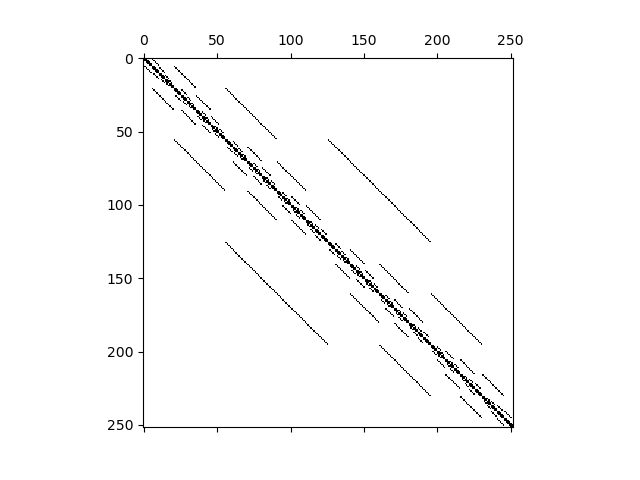

In [118]:
%matplotlib notebook
plt.spy(H_direct)

In [119]:
etI,vtI,k,ee0,ee1,ee2,eer0,eer1 = LancFirat(H_direct,-25)

<IPython.core.display.Javascript object>


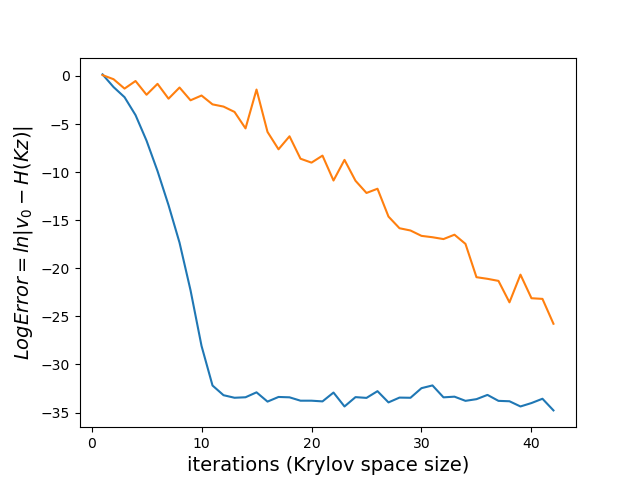

Text(0, 0.5, '$Log Error= ln|v_0 - H (K z) |$')

In [120]:
plt.plot(arange(1,k),log(eer0[2:k+1]),arange(1,k),log(eer1[2:k+1]))
plt.xlabel("iterations (Krylov space size)",size=14)
plt.ylabel("$Log Error= ln|v_0 - H (K z) |$",size=14)

<IPython.core.display.Javascript object>


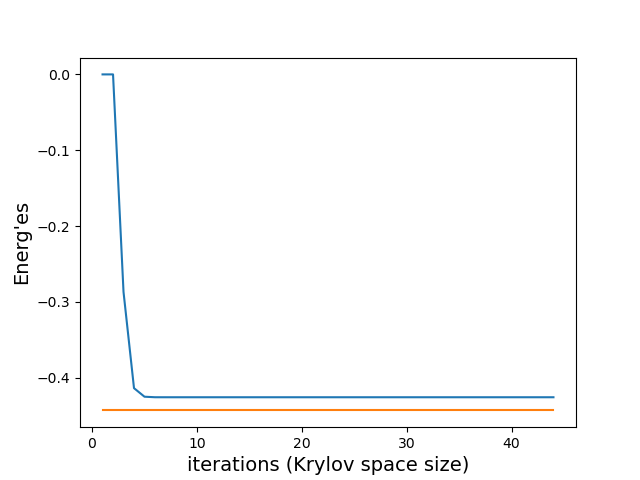

Text(0, 0.5, "Energ'es")

In [125]:
%matplotlib notebook
plt.plot(np.arange(1,k),ee0[0:k-1]/(1.*L),np.arange(1,k),(0.25-log(2))*np.ones((k-1,)))
plt.xlabel("iterations (Krylov space size)",size=14)
plt.ylabel("Energ'es",size=14)

Therefore, we are ready to generate our function:

In [126]:
def XXZfiratDirect(Jz,L,Nup):
    J = 1.
    UnVecs=combs(L,Nup)
    Hlen = len(UnVecs)
    diag0Vec = sum((UnVecs[:,0:L-1]-0.5)*(UnVecs[:,1:L]-0.5),1)
    interm = mod(UnVecs[:,0:L-1]+UnVecs[:,1:L],2)
    xL,yL = interm.shape
    bbOverlap = np.zeros((xL,yL,Hlen))
    for i1 in np.arange(Hlen):
        bbOverlap[:,:,i1] = interm[i1,:]*interm
    HIndicesSz0 = abs(np.dot(UnVecs,2**np.arange(L-1,-1,-1))-2**L+1)
    HIndArray = np.dot(np.ones((len(HIndicesSz0),1),dtype='double'),reshape(HIndicesSz0,[1,len(HIndicesSz0)]))
    hNeig = zeros((xL,xL),dtype='double')
    for i1 in np.arange(L):
        hNeig = hNeig + (abs(HIndArray.T-HIndArray)==2**i1).astype(int)
    H_direct = Jz*np.diag(diag0Vec,0) + 0.5*hNeig
    return H_direct

In [127]:
L = 10
Jz = 1.
H_Heis = XXZfiratDirect(Jz,L,int(L/2))
etI,vtI,k,ee0,ee1,ee2,eer0,eer1 = LancFirat(H_Heis,-20)

<IPython.core.display.Javascript object>


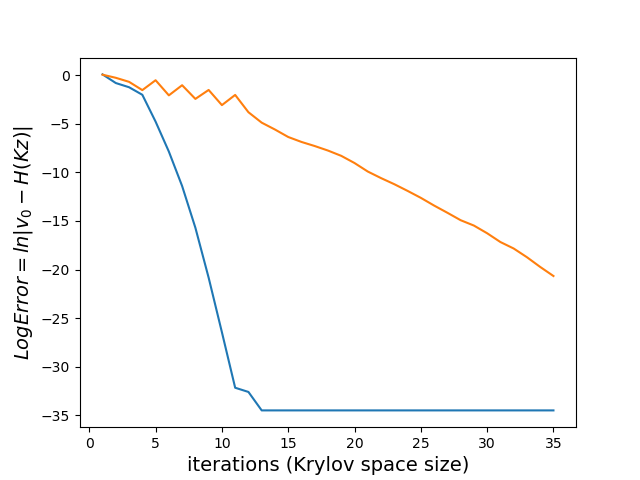

Text(0, 0.5, '$Log Error= ln|v_0 - H (K z) |$')

In [129]:
plt.plot(arange(1,k),log(eer0[2:k+1]),arange(1,k),log(eer1[2:k+1]))
plt.xlabel("iterations (Krylov space size)",size=14)
plt.ylabel("$Log Error= ln|v_0 - H (K z) |$",size=14)

<IPython.core.display.Javascript object>


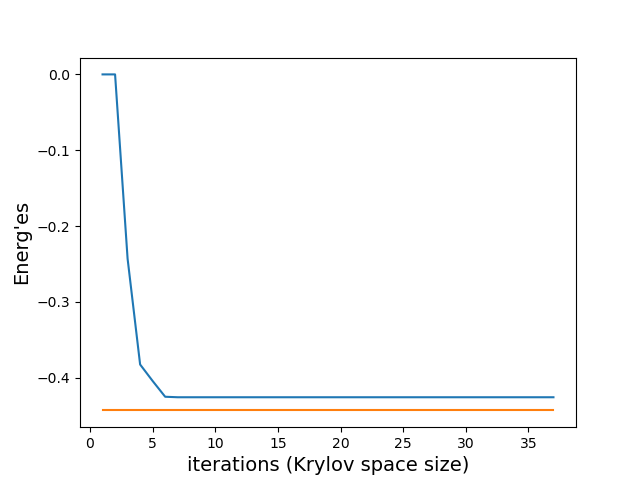

Text(0, 0.5, "Energ'es")

In [131]:
%matplotlib notebook
plt.plot(np.arange(1,k),ee0[0:k-1]/(1.*L),np.arange(1,k),(0.25-log(2))*ones((k-1,)))
plt.xlabel("iterations (Krylov space size)",size=14)
plt.ylabel("Energ'es",size=14)

As a function of $L$, we can calculate the energies,

In [132]:
Lmin = 2
Lmax = 6
Lloop = Lmax - Lmin + 1
EnVecs = np.zeros((3,Lloop))
Lvec = np.arange(Lmin,Lmax+1)
Jz = 1.
for L1 in Lvec:
    L = int(2*L1)
    H_HeisRed = XXZfiratDirect(Jz,L,int(L/2))
    print(H_HeisRed.shape)
    etI,vtI,k,ee0,ee1,ee2,eer0,eer1 = LancFirat(H_HeisRed,-25)
    EnVecs[:,L1-Lmin] = etI[0:3]

(6, 6)
(20, 20)
(70, 70)
(252, 252)
(924, 924)


<IPython.core.display.Javascript object>


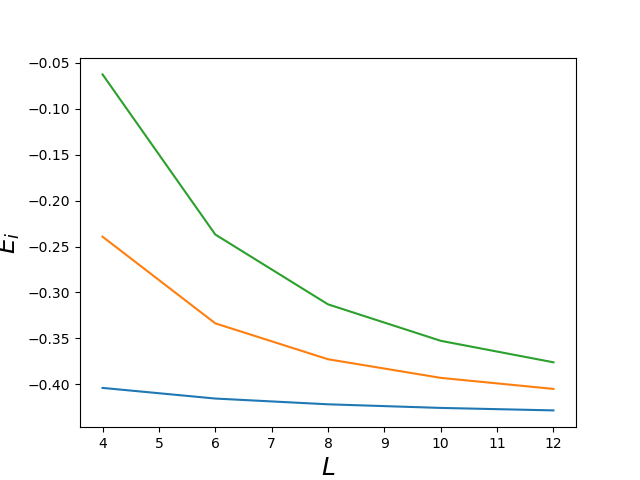

Text(0, 0.5, '$E_i$')

In [133]:
plt.plot(Lvec*2,EnVecs[0,:]/(Lvec*2.),Lvec*2,EnVecs[1,:]/(Lvec*2.),Lvec*2,EnVecs[2,:]/(Lvec*2.))
plt.xlabel('$L$',size=18)
plt.ylabel('$E_i$',size=18)